<img style="float: right;" src="https://static1.squarespace.com/static/5c686c6e16b6401a8c43e978/t/5c87e6d2eb393104199b2c7c/1552410840646/?format=300w">

## GCW Notebook #1 Interactive thresholding 
To get a feel of the range of reflection values in a particular band and how this corresponds to materials on the ground it can be useful to do some interactive thresholding. This notebook explains how to use the ipywidget package on the GBDX platform to test specific bands or an index you have calculated. 



By: Jim Groot and Chris van Diemen @ Green City Watch

### Fix your environment

To make this notebook work it might be necessary to fix your environment, for that reason you can download the req file from [here](https://drive.google.com/file/d/1BP1REyvtOTTZ_Ic3aFdBP1mHKT7ym11c/view?usp=sharingm). Save the req file and use the command below to install dependencies.

In [360]:
!pip install -r /path_to_req_file

In [1]:
# Load libraries
# misc
import numpy as np
import dask.array as da

# GBDX things
from gbdxtools.task import env
from gbdxtools import CatalogImage

# ipywidgets
from ipywidgets import interact, FloatSlider, RadioButtons
from ipywidgets import widgets

# plotting tools
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
%matplotlib inline

# Making plotting better
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Set parameters
# set image parameters, you can find your own id and bbox using the Imagery tool on the left << 

user_catalog_id = '1030050083F8DC00'
user_bbox = '4.872, 52.359, 4.878, 52.362'

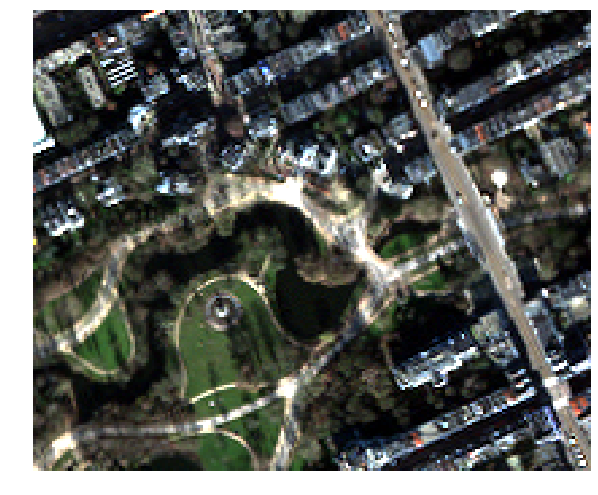

In [3]:
# Get and plot image

# make use of user input
catalog_id = env.inputs.get('catalog_id', user_catalog_id)
bbox_env = env.inputs.get('bbox', user_bbox)
bbox = list(map(float, bbox_env.split(",")))

# get a projected coordinate system for plotting
EPSG = 32700-round((45+list(bbox)[1])/90,0)*100+round((183+list(bbox)[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

# get image
image = CatalogImage(catalog_id, band_type="MS", bbox = bbox, proj = UTM_EPSG_code)

# plot image
image.plot(w=10, h=10)

In [4]:
# get bands 
coastal = image[0,:,:].astype(np.float32)
nir1 = image[6,:,:].astype(np.float32)
nir2 = image[7,:,:].astype(np.float32)
red = image[4,:,:].astype(np.float32)


# perform index calculations 
avg = (nir1+nir2)/2

water_index = (coastal - avg)/(coastal + avg)

ndvi = (nir1 - red)/(nir1 +red)

## Interactive thresholding

For this example we will select the red band to classify the images between high and low values. 

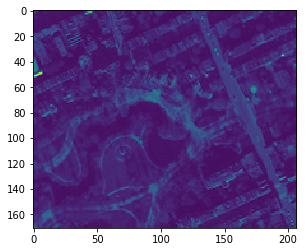

In [5]:
# print red band
plt.imshow(red)

In [6]:
# define data to use in interactive element: 
data = red 

# define number of steps in slider
nr_steps = 100

In [7]:
# create classification array to match image array
dask_classification = data.copy()

# get metrics of the index or band from the dask array
data_min = data.min().compute()
data_max = data.max().compute()
data_mean = data.mean()
# calculate stepsize
data_stepsize = (data_max - data_min) / nr_steps

# define interactive element
treshold_slider = FloatSlider(min=data_min, max=data_max, step=data_stepsize, value=data_mean)

# Build functions for interaction
def interactive_plot(treshold):
    
    # apply threshold
    dask_classification[data < treshold] = 1
    dask_classification[data >= treshold] = 0

    
    # create figure using matplotlib
    fig = plt.figure(num = 0, figsize = (12, 8))#, dpi = 300)
    fig.suptitle("Interactive thresholding, it takes a while to update...", fontsize=14)
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)
    ax4 = ax3.twinx()
    
    # set color scale
    cmap = colors.ListedColormap(['indigo', 'red'])
    
    # plot classification based on threshold 
    cax = ax1.imshow(dask_classification, cmap=cmap, vmin=0, vmax=1)
    
    # plot actual image for reference 
    ax2.imshow(image.rgb())
    
    # plot data histogram
    ax3.hist(data.ravel(), bins = 50)
    
    # add vertical line on threshold
    ax3.axvline(treshold, color='k', linestyle='dashed', linewidth=1)
    
    # improve ink ratio :P
    ax1.axis('off')
    ax2.axis('off')
    
# define interface elements
def build_interface():
    
    clear_output()
    
    widgets.interact(interactive_plot, treshold = treshold_slider)


In [8]:
# excecute the interactive element
# use the slider to interact with the classifcation, it takes a while to update...
build_interface()

interactive(children=(FloatSlider(value=645.7698974609375, description='treshold', max=5770.0, min=31.0, step=…

## iSummary

We have learned how to apply a basic treshold on the red band of WorldView imagery. Then we applied the tresholds interactively to make sense of the results. 

I hope you had fun and learned something :D. 

Best,

Chris

For a further analysis see our second notebook! :) You can find it here: [LINK](https://notebooks.geobigdata.io/hub/notebooks/5exv8b63q72yosz4pnop?tab=code). 